In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py
from scipy import stats
import os

from density_profile_fit_utils import fit_nfw_model, fit_core_nfw_model, fit_isothermal_model
from density_profile_utils import NFW_profile
from density_pericenter_fit_utils import run_best_fit_for_sim, run_best_fit_for_sim_with_mcmc

In [3]:
import matplotlib

plt.style.use("pltstyle.mplstyle")
mycmap = matplotlib.cm.RdYlBu
myblue = mycmap(0.9)
myred =  mycmap(0.1)
color_list = ['olivedrab', myblue, 'peru', myred, 'darkorchid'] # 'midnightblue'])

In [4]:
DATA_PATH = "../data/TangoSIDM/"

IDs = {
    "SigmaConstant00": "CDM",
    "SigmaConstant01": "SigmaConstant01",
#    "SigmaConstant10": "SigmaConstant10", # I will not include this sim. since its cross section is already ruled out by galaxy clusters
    "SigmaVelDep20Anisotropic": "SigmaVel20",
    "SigmaVelDep60Anisotropic": "SigmaVel60", 
    "SigmaVelDep100Anisotropic": "SigmaVel100",
}

## Slope plots - 8

In [7]:
MAX_SATELLITES = 8

filename = f"./outputs/fit_slope_NFW+cNFW+ISO_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "fit_slope_NFW+cNFW+ISO.npy"

if os.path.isfile(filename):
    run_fit = False
    m_save_NFW, m_save_cNFW, m_save_ISO = np.load(filename, allow_pickle=True)

else:
    run_fit = True
    m_save_NFW, m_save_cNFW, m_save_ISO  = [], [], []
    
print(run_fit)

False


#### MCMC Fit

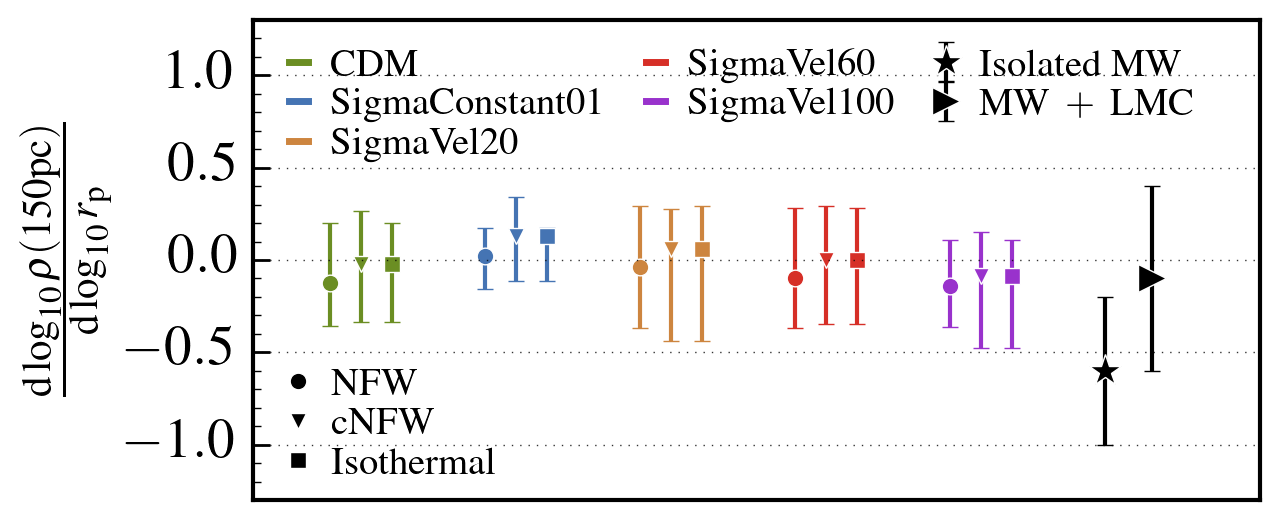

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                # Get NFW profile
                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                
                # Get core-NFW profile
                core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                
                # Get ISO profile
                iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                rho150_iso = np.append(rho150_iso, _rho_150[0])
            
            if run_fit:
                # Fit NFW
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_nfw)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_nfw = np.append(q_nfw, _q)
                m_nfw = np.append(m_nfw, _m)
                
                # Fit core-NFW
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_core_nfw)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_core_nfw = np.append(q_core_nfw, _q)
                m_core_nfw = np.append(m_core_nfw, _m)
                
                # Fit ISO
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_iso)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_iso = np.append(q_iso, _q)
                m_iso = np.append(m_iso, _m)
    
    
    if run_fit:
        m_save_NFW.append(m_nfw)
        m_save_cNFW.append(m_core_nfw)
        m_save_ISO.append(m_iso)
    else:
        m_nfw = m_save_NFW[i]
        m_core_nfw = m_save_cNFW[i]
        m_iso = m_save_ISO[i]
        
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()


# Save fit
if run_fit:
    m_save_NFW = np.array(m_save_NFW, dtype=object)
    m_save_cNFW = np.array(m_save_cNFW, dtype=object)
    m_save_ISO = np.array(m_save_cNFW, dtype=object)
    np.save(filename, (m_save_NFW, m_save_cNFW, m_save_ISO))
    
plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_mcmc_fit_{MAX_SATELLITES}.png', dpi=200)
plt.show()

#### Best fit

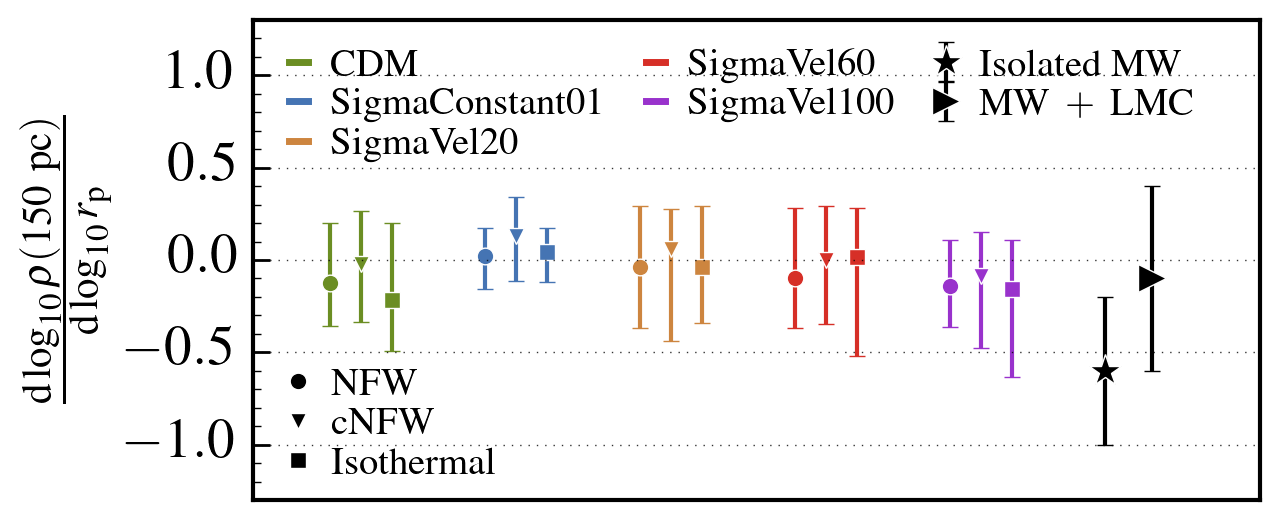

In [9]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                # Get NFW profile
                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                
                # Get core-NFW profile
                core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                
                # Get ISO profile
                iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                rho150_iso = np.append(rho150_iso, _rho_150[0])
            
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_best_fit_{MAX_SATELLITES}.png', dpi=200)
plt.show()

## Slope plots - all

If we were to relax the assumption on eight most massive - lower probability of them having simulated systems in agreement with isoleted MW. Spread is decreasing. 

In [14]:
MAX_SATELLITES = None

filename = f"./outputs/fit_slope_NFW+cNFW+ISO_{MAX_SATELLITES}.npy" if MAX_SATELLITES is not None else "fit_slope_NFW+cNFW+ISO.npy"

if os.path.isfile(filename):
    run_fit = False
    m_save_NFW, m_save_cNFW, m_save_ISO = np.load(filename, allow_pickle=True)

else:
    run_fit = True
    m_save_NFW, m_save_cNFW, m_save_ISO  = [], [], []
    
print(run_fit)

False


#### MCMC Fit

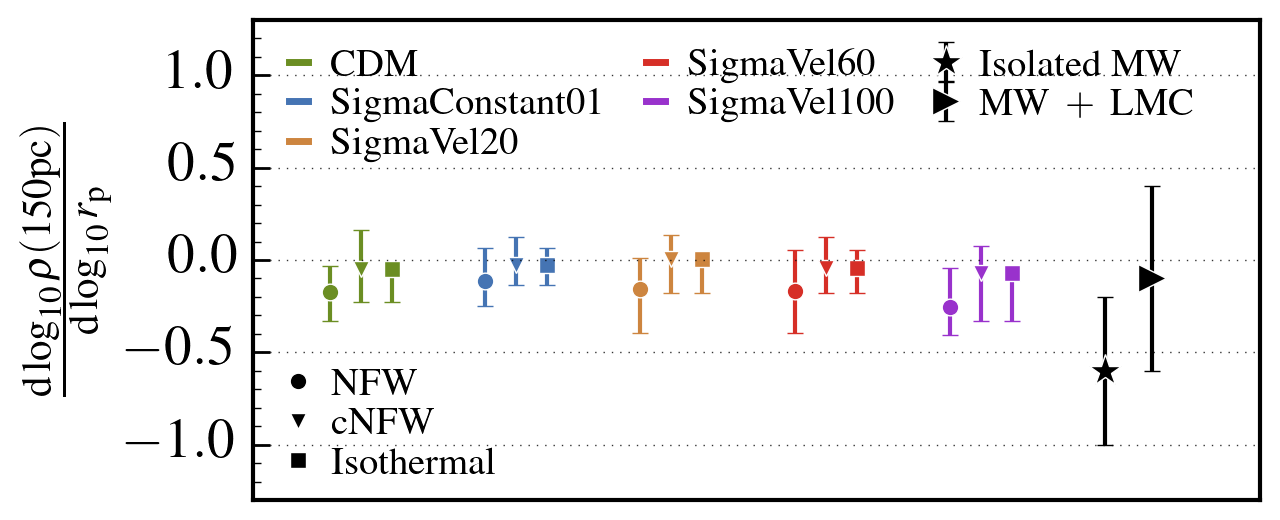

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                # Get NFW profile
                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                
                # Get core-NFW profile
                core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                
                # Get ISO profile
                iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                rho150_iso = np.append(rho150_iso, _rho_150[0])
            
            if run_fit:
                # Fit NFW
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_nfw)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_nfw = np.append(q_nfw, _q)
                m_nfw = np.append(m_nfw, _m)
                
                # Fit core-NFW
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_core_nfw)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_core_nfw = np.append(q_core_nfw, _q)
                m_core_nfw = np.append(m_core_nfw, _m)
                
                # Fit ISO
                samples = run_best_fit_for_sim_with_mcmc(rp, rho150_iso)
                _q, _m = np.median(samples[:, 0]), np.median(samples[:, 1])
                q_iso = np.append(q_iso, _q)
                m_iso = np.append(m_iso, _m)
    
    
    if run_fit:
        m_save_NFW.append(m_nfw)
        m_save_cNFW.append(m_core_nfw)
        m_save_ISO.append(m_iso)
    else:
        m_nfw = m_save_NFW[i]
        m_core_nfw = m_save_cNFW[i]
        m_iso = m_save_ISO[i]
        
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()


# Save fit
if run_fit:
    m_save_NFW = np.array(m_save_NFW, dtype=object)
    m_save_cNFW = np.array(m_save_cNFW, dtype=object)
    m_save_ISO = np.array(m_save_cNFW, dtype=object)
    np.save(filename, (m_save_NFW, m_save_cNFW, m_save_ISO))
    
plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_mcmc_fit_{MAX_SATELLITES}.png', dpi=200)
plt.show()

#### Best fit

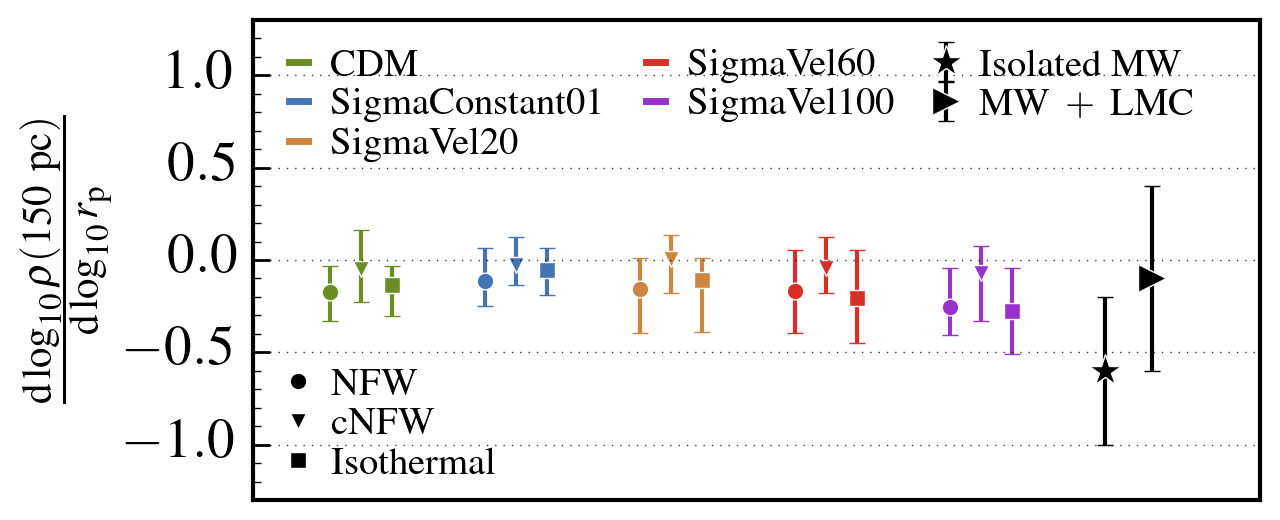

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(6.5, 3), dpi=200)

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    q_nfw, q_core_nfw, q_iso = [], [], []
    m_nfw, m_core_nfw, m_iso = [], [], []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150_nfw, rho150_core_nfw, rho150_iso, M200 = [], [], [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:MAX_SATELLITES]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                # Get NFW profile
                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                _rho_150 = 10**fit_nfw_model(np.array([0.15]), r_s, log10_rho_s)
                rho150_nfw = np.append(rho150_nfw, _rho_150[0])
                
                # Get core-NFW profile
                core_nfw_fit = data_subhalo['halo_data']['core_nfw_fit']
                log10_M_200, r_c, n, sigma_log10_M200, sigma_r_c, sigma_n = core_nfw_fit
                _rho_150 = 10**fit_core_nfw_model(np.array([0.15]), log10_M_200, r_c, n)
                rho150_core_nfw = np.append(rho150_core_nfw, _rho_150[0])
                
                # Get ISO profile
                iso_fit = data_subhalo['halo_data']['iso_fit'][:]
                r_0, log10_rho_0, sigma_r_0, sigma_log10_rho_0 = iso_fit
                _rho_150 = 10**fit_isothermal_model(np.array([0.15, 0.15]), r_0, log10_rho_0)
                rho150_iso = np.append(rho150_iso, _rho_150[0])
            
            # Fit NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_nfw)
            q_nfw = np.append(q_nfw, _q)
            m_nfw = np.append(m_nfw, _m)
            
            # Fit core-NFW
            _q, _m = run_best_fit_for_sim(rp, rho150_core_nfw)
            q_core_nfw = np.append(q_core_nfw, _q)
            m_core_nfw = np.append(m_core_nfw, _m)
            
            # Fit ISO
            _q, _m = run_best_fit_for_sim(rp, rho150_iso)
            q_iso = np.append(q_iso, _q)
            m_iso = np.append(m_iso, _m)
    

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_nfw) - np.percentile(m_nfw,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_nfw)
    plt.errorbar(np.array([i]), np.array(np.median(m_nfw)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_core_nfw) - np.percentile(m_core_nfw,16)
    merr[1,0]= np.percentile(m_core_nfw,84) - np.median(m_core_nfw)
    plt.errorbar(np.array([i])+0.2, np.array(np.median(m_core_nfw)), yerr=merr, marker='v', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    merr = np.zeros((2, 1))
    merr[0,0]= np.median(m_iso) - np.percentile(m_iso,16)
    merr[1,0]= np.percentile(m_nfw,84) - np.median(m_iso)
    plt.errorbar(np.array([i])+0.4, np.array(np.median(m_iso)), yerr=merr, marker='s', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5) #, label=fr'$\mathrm{{{id_name}}}$')
    
    plt.plot([], [], color=color_list[i], lw=2.5, label=fr'$\mathrm{{{id_name}}}$')

    ####
    file.close()

plt.grid('True')
plt.errorbar(np.array([i+1]), np.array(-0.6), yerr=np.ones((2, 1))*0.4, marker='*', markersize=12, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{Isolated\ MW}$', color='black')
plt.errorbar(np.array([i+1.3]), np.array(-0.1), yerr=np.ones((2, 1))*0.5, marker='>', markersize=10, 
            markeredgecolor="white", ls='none', lw=1.5, label=r'$\mathrm{MW\ +\ LMC}$', color='black')
plt.xticks([])
plt.xlim([-0.5, 6])
plt.ylim([-1.3, 1.3])
plt.ylabel(r'$\frac{{\mathrm{d}}\log_{10}\rho(150\ \mathrm{pc})}{{\mathrm{d}}\log_{10}r_{\mathrm{p}}}$')

ax.legend(loc=[0.02,0.67], labelspacing=0.1, handlelength=0.5, handletextpad=0.6, frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)

ax2 = ax.twinx()
ax2.axis('off')
ax2.errorbar([], [], yerr=[], marker='o', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{NFW}$')
ax2.errorbar([], [], yerr=[], marker='v', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{cNFW}$')
ax2.errorbar([], [], yerr=[], marker='s', markersize=6, color='k', markeredgecolor="white", ls='none', lw=0, label=r'$\mathrm{Isothermal}$')
ax2.legend(loc=[0.02,0.005], ncol=1, labelspacing=0.1, handlelength=0.5, handletextpad=0.6, 
           edgecolor='white', frameon=False, facecolor='goldenrod', framealpha=0.3, fontsize=14, columnspacing=1, numpoints=1)

####
plt.savefig(f'figures/Density_pericenter_slope_best_fit_{MAX_SATELLITES}.png', dpi=200)
plt.show()

## Correlation coefficients

In [16]:
GAIA_PATH = "../data/Gaia/"
Kaplinghat_data = pd.read_csv(GAIA_PATH+"Kaplinghat_2019.csv").to_numpy()

dSph = Kaplinghat_data[:,0]
dSph = dSph[::2]

num_satellites = 8
dSph = dSph[:-1]

r_p_Isolated = np.zeros((3,num_satellites)) # Reading pericenter assuming isolated MW
r_p_LMC = np.zeros((3,num_satellites))      # Reading pericenter assuming MW perturbed by LMC
rho_150pc_K19 = np.zeros((3,num_satellites)) # Reading Kaplinghat+ 2019 determination under NFW


for i, dSphi in enumerate(dSph):
    filename = "Cardona_2023_"+dSphi+".csv"
    data = pd.read_csv(GAIA_PATH + filename).to_numpy()
    r_p_Isolated[0,i] = data[2,0] # Pericenter [kpc]
    r_p_Isolated[1,i] = data[2,1] # (Error) Pericenter [kpc]
    r_p_Isolated[2,i] = data[2,2] # (Error) Pericenter [kpc]
    r_p_LMC[0,i] = data[3,0] # Pericenter [kpc]
    r_p_LMC[1,i] = data[3,1] # Pericenter [kpc]
    r_p_LMC[2,i] = data[3,2] # Pericenter [kpc]
    rho_150pc_K19[0,i] = data[8,0] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[1,i] = data[8,1] * 1e7 # Central density [Msun/kpc^3]
    rho_150pc_K19[2,i] = data[8,2] * 1e7 # Central density [Msun/kpc^3]

In [17]:
x = np.log10(r_p_Isolated[0,:])
y = np.log10(rho_150pc_K19[0,:])
pearson_obs_MW = stats.pearsonr(x, y).statistic
spearman_obs_MW = stats.spearmanr(x, y).statistic

x = np.log10(r_p_LMC[0,:])
y = np.log10(rho_150pc_K19[0,:])
pearson_obs_MW_LMC = stats.pearsonr(x, y).statistic
spearman_obs_MW_LMC = stats.spearmanr(x, y).statistic


In [18]:
for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    pearson_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            pearson_sim = np.append(pearson_sim, stats.pearsonr(x, y).statistic)

    print(id_name, 'Obs')
    print(np.median(pearson_sim),pearson_obs_MW, pearson_obs_MW_LMC)
    print('===')

CDM Obs
-0.30686465526576645 -0.6218178555723977 -0.16929150703890178
===
SigmaConstant01 Obs
-0.19382565581039457 -0.6218178555723977 -0.16929150703890178
===
SigmaVel20 Obs
-0.19938772876035143 -0.6218178555723977 -0.16929150703890178
===
SigmaVel60 Obs
-0.12466312252360678 -0.6218178555723977 -0.16929150703890178
===
SigmaVel100 Obs
-0.2050587931863062 -0.6218178555723977 -0.16929150703890178
===


-0.3323766789164866
0.02650865591515319
-0.06439818140469768
-0.06553421700304476
-0.16352495917629864


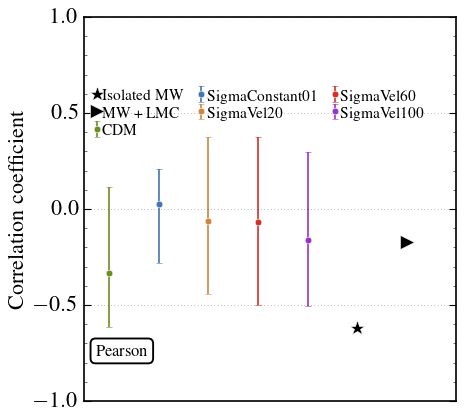

In [19]:
plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    pearson_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:10]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            pearson_sim = np.append(pearson_sim, stats.pearsonr(x, y).statistic)

    print(np.median(pearson_sim))

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(pearson_sim) - np.percentile(pearson_sim,16)
    merr[1,0]= np.percentile(pearson_sim,84) - np.median(pearson_sim)
    plt.errorbar(np.array([i]), np.array(np.median(pearson_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.plot(np.array([i+1]), np.array(pearson_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(pearson_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=1, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Pearson', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
plt.savefig('figures/Density_pericenter_correlation_pearson.png',dpi=300)
plt.show()

-0.32121212121212117
0.01818181818181818
-0.06666666666666665
-0.06666666666666665
-0.13939393939393938


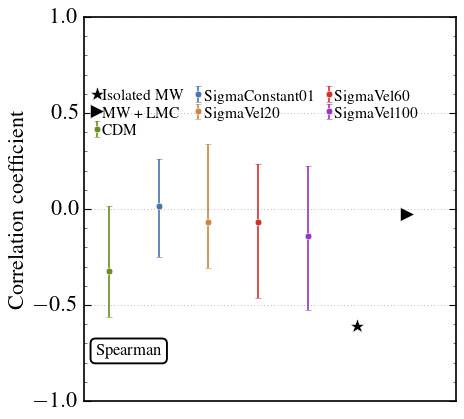

In [20]:
plt.figure()
ax = plt.subplot(1,1,1)
plt.grid('True')

for i, (id, id_name) in enumerate(IDs.items()):
    file = h5py.File(DATA_PATH+f"{id}.hdf5", "a")

    spearman_sim = []
    # Add simulations points
    for idx in file.keys():

        if file[f'{idx}'].attrs.get("main_halo_of") is not None:   
            subhalo_idxs = file[f'{idx}'].attrs.get("main_halo_of")

            rp, rho150, M200 = [], [], []
            # Get satellites of MW halo
            for subhalo_idx in subhalo_idxs[:10]:
                data_subhalo = file[f'{subhalo_idx}']

                # Get pericenter
                _rp = data_subhalo["tree_data"]["pericenter"][1]
                _rp = _rp[0] if _rp.shape==(1,) else _rp
                rp = np.append(rp, _rp)

                nfw_fit = data_subhalo['halo_data']['nfw_fit']
                r_s, log10_rho_s, sigma_r_s, sigma_log10_rho_s = nfw_fit
                rho_s = 10**log10_rho_s
                _rho_150 = NFW_profile(np.array([0.15]), rho_s, r_s)
                rho150 = np.append(rho150, _rho_150[0])
            
            x = np.log10(rp)
            y = np.log10(rho150)
            spearman_sim = np.append(spearman_sim, stats.spearmanr(x, y).statistic)

    print(np.median(spearman_sim))

    merr = np.zeros((2, 1))
    merr[0,0]= np.median(spearman_sim) - np.percentile(spearman_sim,16)
    merr[1,0]= np.percentile(spearman_sim,84) - np.median(spearman_sim)
    plt.errorbar(np.array([i]), np.array(np.median(spearman_sim)), yerr=merr, marker='o', markersize=6, color=color_list[i],
                 markeredgecolor="white", ls='none', lw=1.5, label=id_name)

    ####
    file.close()

plt.plot(np.array([i+1]), np.array(spearman_obs_MW), marker='*', markersize=14, 
         markeredgecolor="white", label='Isolated MW', color='black')

plt.plot(np.array([i+2]), np.array(spearman_obs_MW_LMC), marker='>', markersize=12, 
         markeredgecolor="white", label='MW + LMC', color='black')

plt.legend(loc=[0.01,0.67],labelspacing=0.2, handlelength=0.3, handletextpad=0.2, 
           frameon=False, fontsize=14, ncol=3, columnspacing=0.8, numpoints=1)
plt.xticks([])
plt.ylabel('Correlation coefficient')
plt.axis([-0.5, 7, -1, 1.0])

props = dict(boxstyle='round', fc='white', ec='black', alpha=1)
plt.text(0.03, 0.15, 'Spearman', transform=ax.transAxes, fontsize=15, verticalalignment='top', bbox=props, zorder=1000)

####
plt.savefig('figures/Density_pericenter_correlation_spearman.png',dpi=300)
plt.show()

##### 